# Ibovespa forecasting using neural networks

## Machine Learning Engineer Nanodegree - Capstone Proposal

### Import python packages

In [1]:
import os
import pandas as pd

from torch.nn import L1Loss
from torch.optim import Adam

from ibov.utils import load_config
from ibov.model import train, torch_data, model_fc1h, model_fc2h, model_lstm
from ibov.feature import create_lags, consolidate_features, create_delta_sign, label_train_test, normalize_target
from ibov.request import get_history
from ibov.metrics import calculate_metrics, model_prediction, benchmark_model, graphical_evaluation

### Loading Configs

In [2]:
# Load config dict
config = load_config()

In [3]:
# Feature Engineering Configs
window = config.get("feature").get("window")
variables = config.get("feature").get("variables")
test_split = config.get("feature").get("split").get("test")
valid_split = config.get("feature").get("split").get("valid")

# Data Configs
data_dir = config.get("data").get("dir")
ibov_ticker = config.get("ibov").get("ticker")
filename = config.get("data").get("file")
data_size = config.get("data").get("size")
ascending = config.get("data").get("ascending") == 'True'

# Model configurations
dropout = config.get("model").get("dropout")
hidden_layer = config.get("model").get("hidden_layer")
lr = config.get("model").get("lr")
seed = config.get("model").get("seed")
epochs = config.get("model").get("epochs")

### Data Preparation

In [4]:
# Invoke yahoo finance api
#ibovespa = get_history(ticker=ibov_ticker, data_size=data_size, ascending=ascending)

# Save data on disk
#ibovespa.to_csv(os.path.join(data_dir, filename), index=False)

# Read from disk
ibovespa = pd.read_csv(os.path.join(data_dir, filename))

# Label datapoint as train or test dataset
ibovespa = label_train_test(ibovespa, split=test_split, split_valid=valid_split, ascending=ascending)

### Feature Engineering

In [5]:
# Target Normalization
ibovespa = normalize_target(ibovespa, target="close")

In [6]:
# Create lag variables
ibov_lags_df = create_lags(ibovespa, window=window, var="close", index="date")

In [7]:
# Create sign variables
ibov_delta_sign_df = create_delta_sign(ibov_lags_df, var="lags", index="date", window=window)

In [8]:
# Consolidate raw data with features
master_table = consolidate_features(ibovespa, "date", ibov_lags_df, ibov_delta_sign_df)

In [9]:
# Load data to torch standard
train_loader, train_x_tensor, train_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="train")

valid_loader, valid_x_tensor, valid_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="valid")

test_loader, test_x_tensor, test_y_tensor = \
    torch_data(master_table, target="target", variables=variables, group_var="group", batch=50, group="test")

### Training step

In [27]:
from torch import nn
import torch

In [61]:
class model_fc1h(nn.Module):

    def __init__(self, input_layer, hidden_layer=50, dropout=0.25):

        super(model_fc1h, self).__init__()
        
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(input_layer, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, 1)
        
    def forward(self, input):

        x = self.fc1(input)
        x = self.dropout(x)
        output = self.fc2(x)

        return output[:,0]

In [62]:
# Model definition
model = model_fc1h(input_layer=window, hidden_layer=hidden_layer, dropout=dropout)
criterion = L1Loss()
optimizer = Adam(model.parameters(), lr=lr)

In [63]:
# Model training
train(model, train_loader, valid_loader, criterion, optimizer, epochs=epochs, seed=seed)

16:41:53, epoch: 0, train: 3.356, valid: 0.42
16:41:53, epoch: 1, train: 2.01, valid: 0.197
16:41:53, epoch: 2, train: 1.116, valid: 0.03
16:41:53, epoch: 3, train: 0.751, valid: 0.113
16:41:53, epoch: 4, train: 0.892, valid: 0.106
16:41:53, epoch: 5, train: 0.88, valid: 0.046
16:41:53, epoch: 6, train: 0.74, valid: 0.034
16:41:53, epoch: 7, train: 0.812, valid: 0.037
16:41:53, epoch: 8, train: 0.768, valid: 0.026
16:41:53, epoch: 9, train: 0.712, valid: 0.034
16:41:53, epoch: 10, train: 0.703, valid: 0.038
16:41:53, epoch: 11, train: 0.727, valid: 0.03
16:41:53, epoch: 12, train: 0.65, valid: 0.027
16:41:53, epoch: 13, train: 0.679, valid: 0.026
16:41:53, epoch: 14, train: 0.743, valid: 0.028
16:41:53, epoch: 15, train: 0.733, valid: 0.027
16:41:53, epoch: 16, train: 0.674, valid: 0.027
16:41:53, epoch: 17, train: 0.611, valid: 0.029
16:41:53, epoch: 18, train: 0.546, valid: 0.028
16:41:53, epoch: 19, train: 0.618, valid: 0.026
16:41:53, epoch: 20, train: 0.608, valid: 0.026
16:41:53,

### Evaluation

In [64]:
train_true.shape

(292,)

In [65]:
train_pred.shape

(1, 292)

In [66]:
# Model performance on Training dataset
train_true, train_pred = model_prediction(model, train_x_tensor, train_y_tensor)
calculate_metrics(train_true, train_pred)

(0.028861197400582978, 0.45353159851301117)

In [67]:
# Model performance on Validation dataset
valid_true, valid_pred = model_prediction(model, valid_x_tensor, valid_y_tensor)
calculate_metrics(valid_true, valid_pred) 

(0.028373699735950778, 0.4)

In [68]:
# Model performance on Test dataset
test_true, test_pred = model_prediction(model, test_x_tensor, test_y_tensor)
calculate_metrics(test_true, test_pred)

(0.017211254300742315, 0.26666666666666666)

### Benchmark Model

In [69]:
# Set and Evaludate Benchmark Model
bmk_true, bmk_pred = benchmark_model(test_y_tensor, valid_y_tensor)
calculate_metrics(bmk_true, bmk_pred)

(0.027898712404843033, 0.4210526315789474)

### Graphical Evaluation

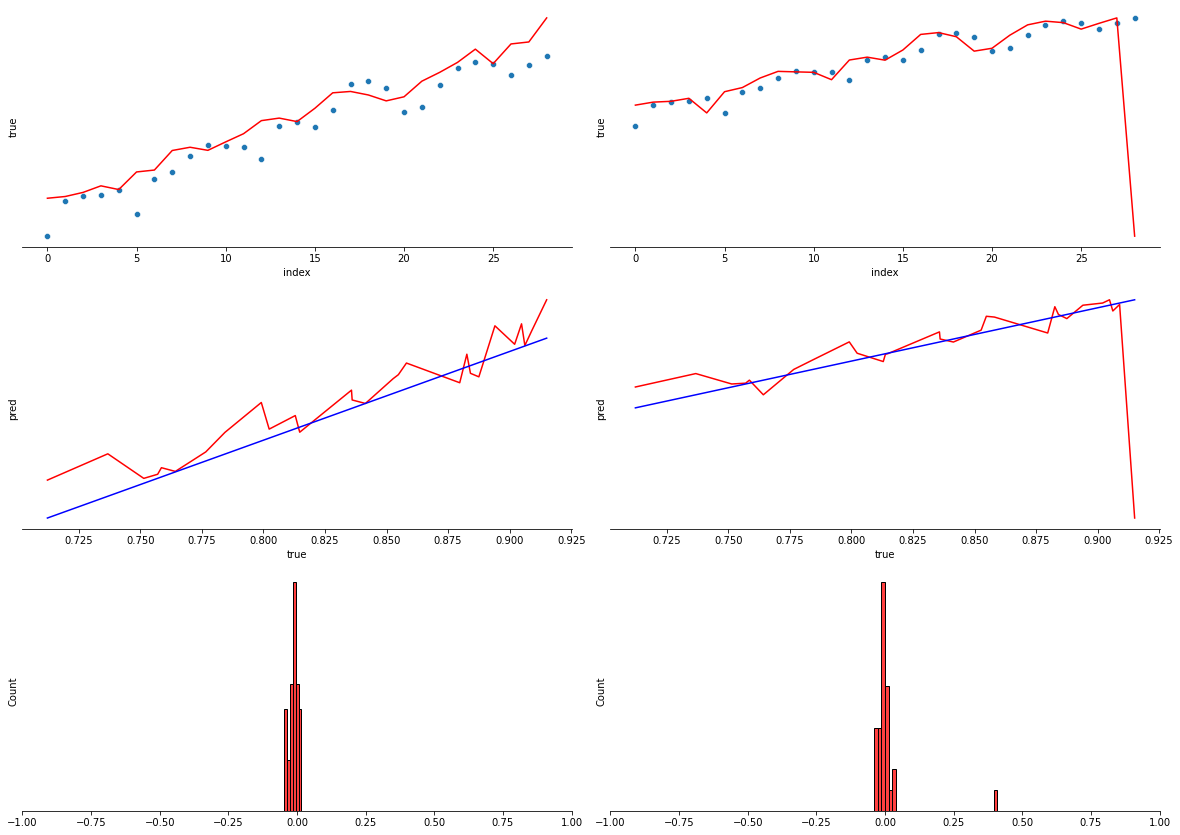

In [70]:
# Evaluate test dataset graphically
graphical_evaluation(test_true, test_pred, bmk_true, bmk_pred)